In [69]:
import sys
import os

sys.path.append(os.path.abspath(".."))

import numpy as np
import torch
from neuralop.data.datasets.custom_darcy import CustomDarcyDataset, load_darcy_flow
import matplotlib.pyplot as plt
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from copy import deepcopy
import math

In [70]:
resolution = 64

train_loader, test_loaders, data_processor = load_darcy_flow(
    root_dir="./data/",
    dataset_name='darcy_ZD_PWC',
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=64,
    test_resolutions=[64]
)

Loading test db for resolution 64 with 50 samples 


In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tfno_model = TFNO(
    n_modes=(16, 16), 
    hidden_channels=64,
    in_channels=1,
    out_channels=1,
    factorization='tucker',
    implementation='factorized',
    rank=0.05
)
tfno_model = tfno_model.to(device)

n_params = count_model_params(tfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 270145 parameters.


In [72]:
n_epochs = 100
optimizer = AdamW(tfno_model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

In [73]:
trainer = Trainer(model=tfno_model, 
                  n_epochs=n_epochs,
                  device=device,
                  data_processor=data_processor,
                  wandb_log=True,
                  eval_interval=50,
                  use_distributed=False,
                  verbose=True)

trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 64, 64])
[0] time=0.19, avg_loss=1.0012, train_err=50.0576
Eval: 64_h1=1.0834, 64_l2=0.5678
[50] time=0.17, avg_loss=0.6965, train_err=34.8228
Eval: 64_h1=0.7140, 64_l2=0.3857


{'train_err': 20.950919148713485,
 'avg_loss': 0.4190183829742697,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.16720822267234325}

L2 error (0) : 0.4468415132325042
L2 error (1) : 0.26717644821946424
L2 error (2) : 0.2786931800087166


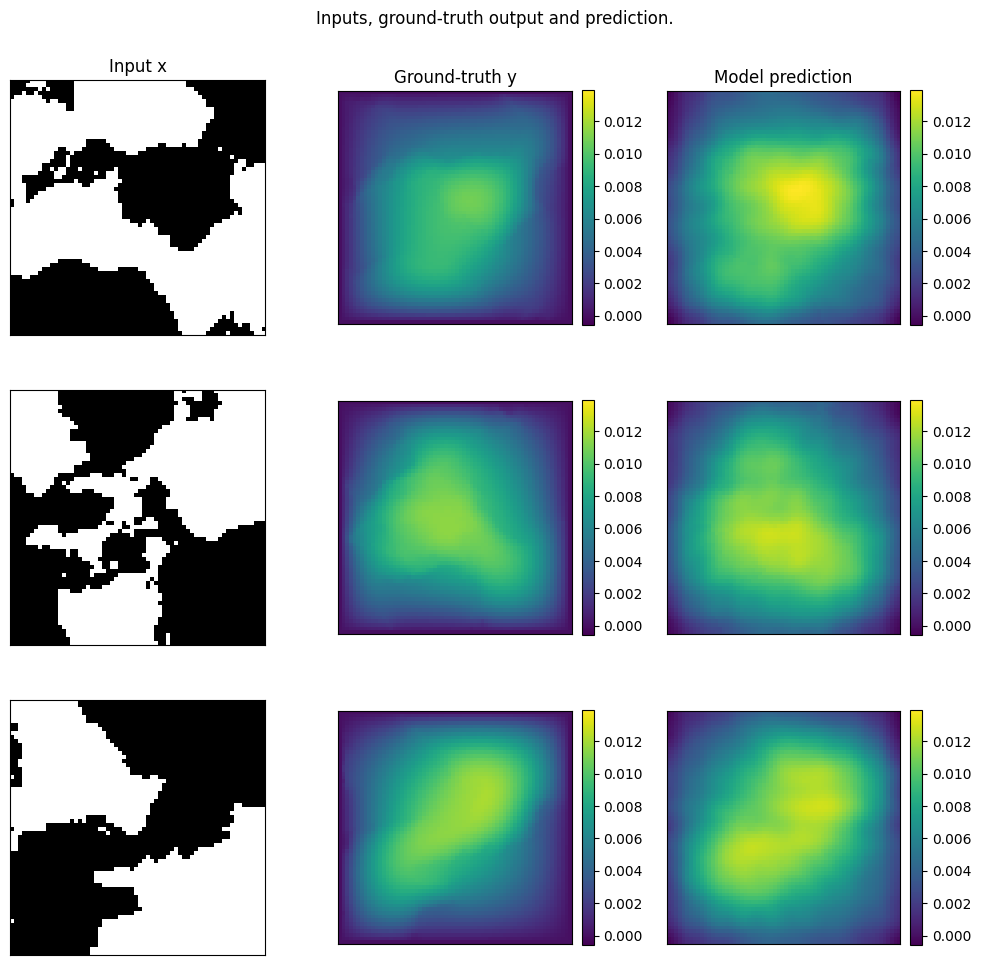

In [74]:
test_samples = test_loaders[64].dataset

# Step 1: Compute global min and max for consistent color scaling
vmin, vmax = float('inf'), float('-inf')
for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x']
    y = data['y']
    out = tfno_model(x.unsqueeze(0))

    y = data_processor.out_normalizer.inverse_transform(y).squeeze().detach()
    out = data_processor.out_normalizer.inverse_transform(out).squeeze().detach()

    vmin = min(vmin, y.min().item(), out.min().item())
    vmax = max(vmax, y.max().item(), out.max().item())

# Step 2: Plot with consistent vmin/vmax and add colorbars
fig = plt.figure(figsize=(10, 10))

for index in range(3):
    data = test_samples[index]
    data = data_processor.preprocess(data, batched=False)

    x = data['x'].to(device)
    y = data['y'].to(device)
    out = tfno_model(x.unsqueeze(0)).squeeze().detach()

    y = data_processor.out_normalizer.inverse_transform(y)
    out = data_processor.out_normalizer.inverse_transform(out)

    # Input x
    ax = fig.add_subplot(3, 3, index * 3 + 1)
    im = ax.imshow(x[0].cpu(), cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])
    
    # Ground-truth y
    ax = fig.add_subplot(3, 3, index * 3 + 2)
    im = ax.imshow(y.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # Model prediction
    ax = fig.add_subplot(3, 3, index * 3 + 3)
    im = ax.imshow(out.squeeze().cpu(), vmin=vmin, vmax=vmax)
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    print(f'L2 error ({index}) : {torch.norm(out - y) / torch.norm(y)}')

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
plt.show()

In [75]:
train_loader_list, test_loader_list, data_processor_list = load_darcy_flow(
    root_dir="data",
    dataset_name="darcy_ZD_PWC",
    n_train=1000,
    n_tests=[50],
    batch_size=100,
    test_batch_sizes=[50],
    train_resolution=64,
    test_resolutions=[64],
    decompose_multigrid=True,
    L=2
)

Loading test db for resolution 64 with 50 samples 


/home/haltmayermarc/Samsung_new/neuraloperator/neuralop/data/datasets/pt_dataset.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(
/home/haltmayermarc/

In [76]:
train_loader_list[0].dataset.x.shape, train_loader_list[0].dataset.y.shape, train_loader_list[0].dataset.x.min(), train_loader_list[0].dataset.x.max(), train_loader_list[0].dataset.y.min(), train_loader_list[0].dataset.y.max()

(torch.Size([50, 3, 16, 16]),
 torch.Size([50, 1, 16, 16]),
 tensor(0.),
 tensor(12.),
 tensor(0., dtype=torch.float64),
 tensor(0.0111, dtype=torch.float64))

In [77]:
models = []
for i in range(len(data_processor_list)):
    print("#####################################################")
    print("#### Train model No.", i)
    print("#####################################################")

    model = TFNO(
        n_modes=(16, 16),
        hidden_channels=64,
        in_channels=3,
        out_channels=1,
        factorization='tucker',
        implementation='factorized',
        rank=0.05
    ).to(device)

    n_epochs = 100
    optimizer = AdamW(model.parameters(), lr=8e-3, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

    trainer = Trainer(
        model=model,
        n_epochs=n_epochs,
        device=device,
        data_processor=data_processor_list[i],
        eval_interval=20,
        verbose=True
    )

    trainer.train(
        train_loader=train_loader_list[i],
        test_loaders=test_loader_list[i],
        optimizer=optimizer,
        scheduler=scheduler,
        training_loss=h1loss,
        eval_losses={'h1': h1loss, 'l2': l2loss}
    )

    models.append(model)

#####################################################
#### Train model No. 0
#####################################################
Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 16, 16])
[0] time=0.16, avg_loss=1.1499, train_err=57.4949
Eval: 64_h1=1.6942, 64_l2=2.5313
[20] time=0.15, avg_loss=0.2238, train_err=11.1875
Eval: 64_h1=0.2290, 64_l2=0.2332
[40] time=0.15, avg_loss=0.1559, train_err=7.7932
Eval: 64_h1=0.2082, 64_l2=0.1979
[60] time=0.14, avg_loss=0.0954, train_err=4.7685
Eval: 64_h1=0.1146, 64_l2=0.1141
[80] time=0.14, avg_loss=0.0735, train_err=3.6729
Eval: 64_h1=0.1036, 64_l2=0.0932
#####################################################
#### Train model No. 1
#####################################################
Training on 50 samples
Testing on [50] samples         on resolutions [64].
Raw outputs of shape torch.Size([50, 1, 16, 16])
[0] time=0.15, avg_loss=1.1281, train_err=56.4037
Eval: 64_h1=0.9599, 64

In [78]:
len(models)

16

In [79]:
def stitch_predictions(models, test_loader_list, data_processor_list,
                       global_res, device):
    # Assume all models have the same local resolution
    local_res = models[0].out_channels_size if hasattr(models[0], "out_channels_size") else \
                next(iter(test_loader_list[0].values())).dataset.y.shape[-1]

    num_per_axis = global_res // local_res
    num_models = num_per_axis ** 2

    full_output = None
    batch_size = None

    with torch.no_grad():
        for idx, model in enumerate(models):
            dp = data_processor_list[idx]
            loader = test_loader_list[idx][global_res]

            xb = loader.dataset.x.to(device)   # [batch, in_channels, local_res, local_res]
            y_pred = model(xb)
            y_pred = dp.out_normalizer.inverse_transform(y_pred)

            if full_output is None:
                batch_size = y_pred.shape[0]
                full_output = torch.zeros(batch_size, 1, global_res, global_res, device=device)

            # Compute tile position
            i = idx // num_per_axis  # row index
            j = idx % num_per_axis   # col index
            r_start, r_end = i * local_res, (i + 1) * local_res
            c_start, c_end = j * local_res, (j + 1) * local_res

            full_output[:, :, r_start:r_end, c_start:c_end] = y_pred

    return full_output

def plot_comparison(y_full, y_reconstructed, y_tfno):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    im0 = axs[0].imshow(y_full.squeeze().cpu(), cmap='viridis')
    axs[0].set_title("Original Solution")
    fig.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(y_tfno.squeeze().cpu(), cmap='viridis')
    axs[1].set_title("Full TFNO Prediction")
    fig.colorbar(im1, ax=axs[1])

    im2 = axs[2].imshow(y_reconstructed.squeeze().cpu(), cmap='viridis')
    axs[2].set_title("Reconstructed from Subdomains")
    fig.colorbar(im2, ax=axs[2])

    im3 = axs[3].imshow((y_reconstructed - y_tfno).abs().squeeze().cpu(), cmap='inferno')
    axs[3].set_title("Reconstruction Error")
    fig.colorbar(im3, ax=axs[3])

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

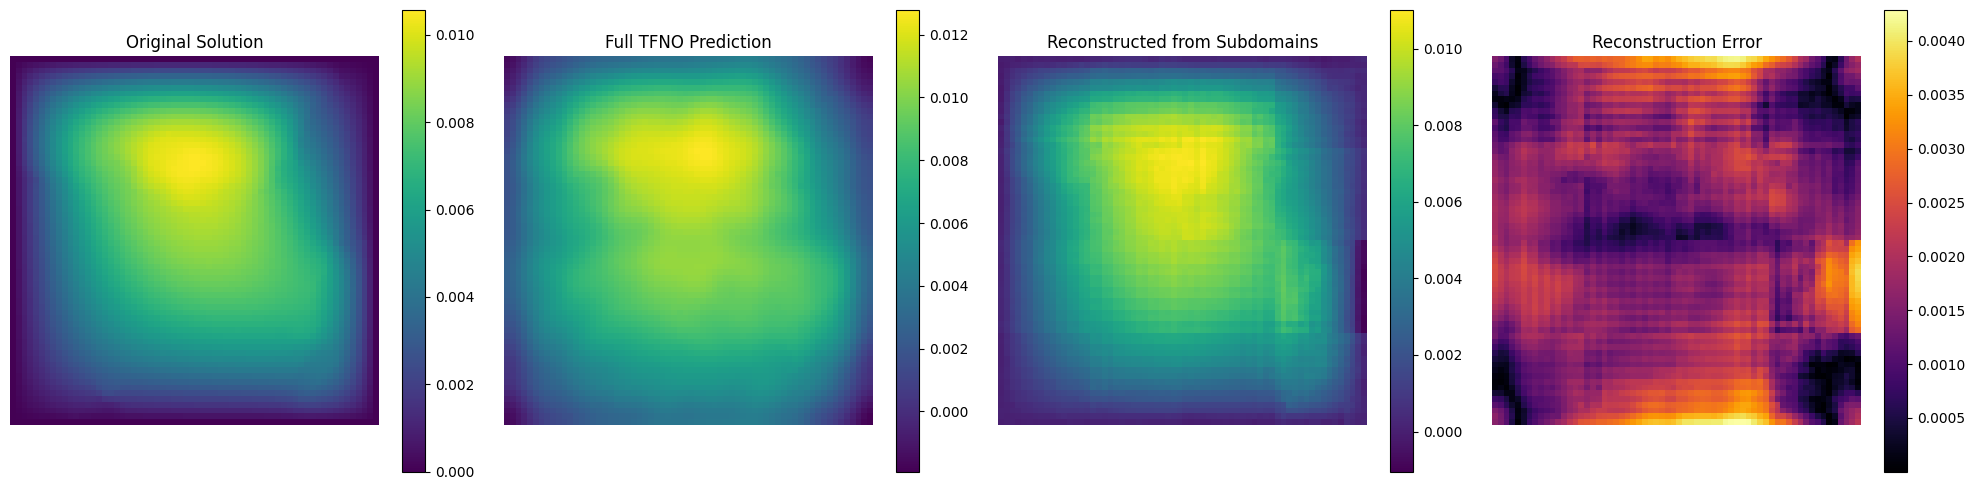

L2 error (TFNO) : 0.3490908136009256
L2 error (MG-TFNO) : 0.07281049327011362


In [85]:
global_res = 64
random_index = np.random.randint(0, test_loaders[resolution].dataset.x.shape[0] - 1)

with torch.no_grad():
    y_tfno = tfno_model(test_loaders[resolution].dataset.x[random_index:random_index+1].to(device))
    y_tfno = data_processor.out_normalizer.inverse_transform(y_tfno)

# Reconstruct output from subdomains
y_reconstructed = stitch_predictions(models, test_loader_list, data_processor_list, resolution, device)

# Get ground truth solution
y_full = test_loaders[resolution].dataset.y[random_index:random_index+1].to(device)

# Plot original, TFNO, subdomain reconstruction
plot_comparison(y_full, y_reconstructed[random_index:random_index+1], y_tfno)

print(f'L2 error (TFNO) : {torch.norm(y_full - y_tfno) / torch.norm(y_full)}')
print(f'L2 error (MG-TFNO) : {torch.norm(y_full - y_reconstructed[random_index:random_index+1]) / torch.norm(y_full)}')

In [87]:
tfno_error = 0
mg_tfno_error = 0

for idx in range(test_loaders[resolution].dataset.x.shape[0]):
    with torch.no_grad():
        y_tfno = tfno_model(test_loaders[resolution].dataset.x[idx:idx+1].to(device))
        y_tfno = data_processor.out_normalizer.inverse_transform(y_tfno)

    # Reconstruct output from subdomains
    y_reconstructed = stitch_predictions(models, test_loader_list, data_processor_list, resolution, device)

    # Get ground truth solution
    y_full = test_loaders[resolution].dataset.y[idx:idx+1].to(device)

    tfno_error += torch.norm(y_full - y_tfno) / torch.norm(y_full)
    mg_tfno_error += torch.norm(y_full - y_reconstructed[idx:idx+1]) / torch.norm(y_full)

tfno_error /= test_loaders[resolution].dataset.x.shape[0]
mg_tfno_error /= test_loaders[resolution].dataset.x.shape[0]

print(f'Average L2 error (TFNO) : {tfno_error}')
print(f'Average L2 error (MG-TFNO) : {mg_tfno_error}')

Average L2 error (TFNO) : 0.27399470216111793
Average L2 error (MG-TFNO) : 0.10425822973822124
